In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import scarches as sca
warnings.filterwarnings("ignore")


import sys
sys.path.append('../scripts')
%load_ext autoreload
%autoreload 2
#%load_ext lab_black

/home/daniele/miniconda3/envs/cross_species/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [ ]:
mouse = sc.read_h5ad('/mnt/storage/Daniele/atlases/mouse/Mouse_Atlas_Harmonised.h5ad')
human = sc.read_h5ad('/mnt/storage/Daniele/atlases/human/Human_Atlas_Harmonised.h5ad')

In [ ]:
orthologous_genes = pd.read_csv('../../mouse/notebooks/human_mouse_hcop_fifteen_column.txt.gz', sep='\t')

In [ ]:
orthologous_genes_map = {k: v for k, v in zip(orthologous_genes['mouse_symbol'], orthologous_genes['human_symbol'])}

In [ ]:
mouse.var['human_symbol'] = mouse.var.index.map(orthologous_genes_map)
mouse.var['human_symbol'].fillna('not_found', inplace=True)

In [ ]:
mouse.var['mouse_symbol'] = mouse.var.index
mouse.var_names = mouse.var['human_symbol'].values

In [ ]:
unique_human_symbols = mouse.var['human_symbol'].value_counts()[lambda x: x == 1].index
mouse = mouse[:, mouse.var['human_symbol'].isin(unique_human_symbols)].copy()

In [ ]:
intersection = list(mouse.var_names.intersection(human.var_names))
len(intersection)

In [ ]:
human = human[:, intersection].copy()
mouse = mouse[:, intersection].copy()

In [ ]:
import anndata as ad

In [ ]:
human.var['manual_gene'] = human.var['Manual_Genes']

In [ ]:
for a in [mouse, human]:
    a.obsm = {}
    a.obsp = {}  # Optional: only if you don’t need the distance/connectivity graph
    a.layers = {}  # Optional: only if raw/count/log data isn’t essential right now

adata = ad.concat([mouse, human], label = 'species', keys=['mouse', 'human'],
                  axis=0, join='inner', merge='same')

In [ ]:
adata.obs['species'].value_counts(), mouse, human

In [ ]:
adata.var['Manual_Genes'] = human.var['Manual_Genes']

In [ ]:
import gc
del mouse
del human
gc.collect()

In [ ]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, )
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000, batch_key='species',)   

In [ ]:
adata.var['highly_variable_intersection'].value_counts()

In [ ]:
adata_hvg = adata[:, adata.var['highly_variable_intersection']].copy()

In [ ]:
batch_key = 'Sample_ID'
celltype_key = 'Level_4'

In [ ]:
import numpy as np
from scipy.sparse import issparse, csr_matrix

def bin_data(adata, binning, key_to_process=None, result_binned_key="binned_data"):
    """
    Bins numerical data into discrete categories based on quantiles,
    without ever converting the full matrix to dense.

    Parameters:
        adata (AnnData): The input data object.
        key_to_process (str): Key in `adata.layers` to process, or None to use `adata.X`.
        binning (int): Number of bins (must be an integer >= 2).
        result_binned_key (str): Key under `adata.layers` to store the binned CSR.

    Raises:
        ValueError: If `binning` is not an integer >=2, or data contains negative values.
    """
    if not isinstance(binning, int) or binning < 2:
        raise ValueError(f"Binning must be an integer >= 2, but got {binning}.")

    # pick the matrix (could be sparse)
    mat = adata.layers[key_to_process] if key_to_process is not None else adata.X

    # Only CSR is supported here
    if not issparse(mat):
        raise ValueError("This implementation requires a CSR matrix input.")
    mat = mat.tocsr()

    # check for negatives in the nonzero data
    if mat.data.min(initial=0) < 0:
        raise ValueError(f"Expecting non-negative data, but got min value {mat.data.min()}.")

    n_rows, n_cols = mat.shape

    # prepare arrays to build new CSR
    binned_data   = []
    binned_indices = []
    binned_indptr = [0]

    all_bin_edges = []

    # loop over rows via CSR indptr
    for i in range(n_rows):
        start, end = mat.indptr[i], mat.indptr[i+1]
        row_data = mat.data[start:end]
        row_cols = mat.indices[start:end]

        if row_data.size == 0:
            # no non-zeros => nothing to append, edges are zeros
            all_bin_edges.append(np.zeros(binning, dtype=float))
            binned_indptr.append(binned_indptr[-1])
            continue

        # compute bin thresholds on non-zero values
        bins = np.quantile(row_data, np.linspace(0, 1, binning - 1))
        # digitize returns 1..(binning-1); we'll store that
        digits = np.digitize(row_data, bins, right=False)

        # append to CSR arrays
        binned_data.extend(digits.tolist())
        binned_indices.extend(row_cols.tolist())
        binned_indptr.append(binned_indptr[-1] + digits.size)

        # record the edges (prepend a zero edge for completeness)
        all_bin_edges.append(np.concatenate(([0.0], bins)))

    # build the new CSR matrix
    binned_csr = csr_matrix(
        (np.array(binned_data, dtype=int),
         np.array(binned_indices, dtype=int),
         np.array(binned_indptr, dtype=int)),
        shape=(n_rows, n_cols),
        dtype=int
    )

    # store
    adata.layers[result_binned_key] = binned_csr
    # bin edges per row
    adata.obsm["bin_edges"] = np.stack(all_bin_edges)


In [ ]:
bin_data(adata_hvg, binning=50, key_to_process=None, result_binned_key="binned_data")

In [ ]:
# hotfix
adata_hvg.obs[batch_key] = adata_hvg.obs[batch_key].astype(str).astype('category')
sca.models.SCVI.setup_anndata(adata_hvg, layer='binned_data', batch_key=batch_key, labels_key=celltype_key)


In [ ]:
vae = sca.models.SCVI(
    adata_hvg,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [ ]:
vae.train(max_epochs=50)

In [ ]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")
scanvae.train(max_epochs=10)

In [ ]:
adata_hvg.obsm['scANVI_emb_final'] = scanvae.get_latent_representation(adata_hvg)
adata.obsm['scANVI_emb_final'] = adata_hvg.obsm['scANVI_emb_final'] 

In [ ]:
from sklearn_ann.kneighbors.annoy import AnnoyTransformer
sc.pp.neighbors(adata, transformer=AnnoyTransformer(15), use_rep='scANVI_emb_final')

In [ ]:
sc.tl.umap(adata)

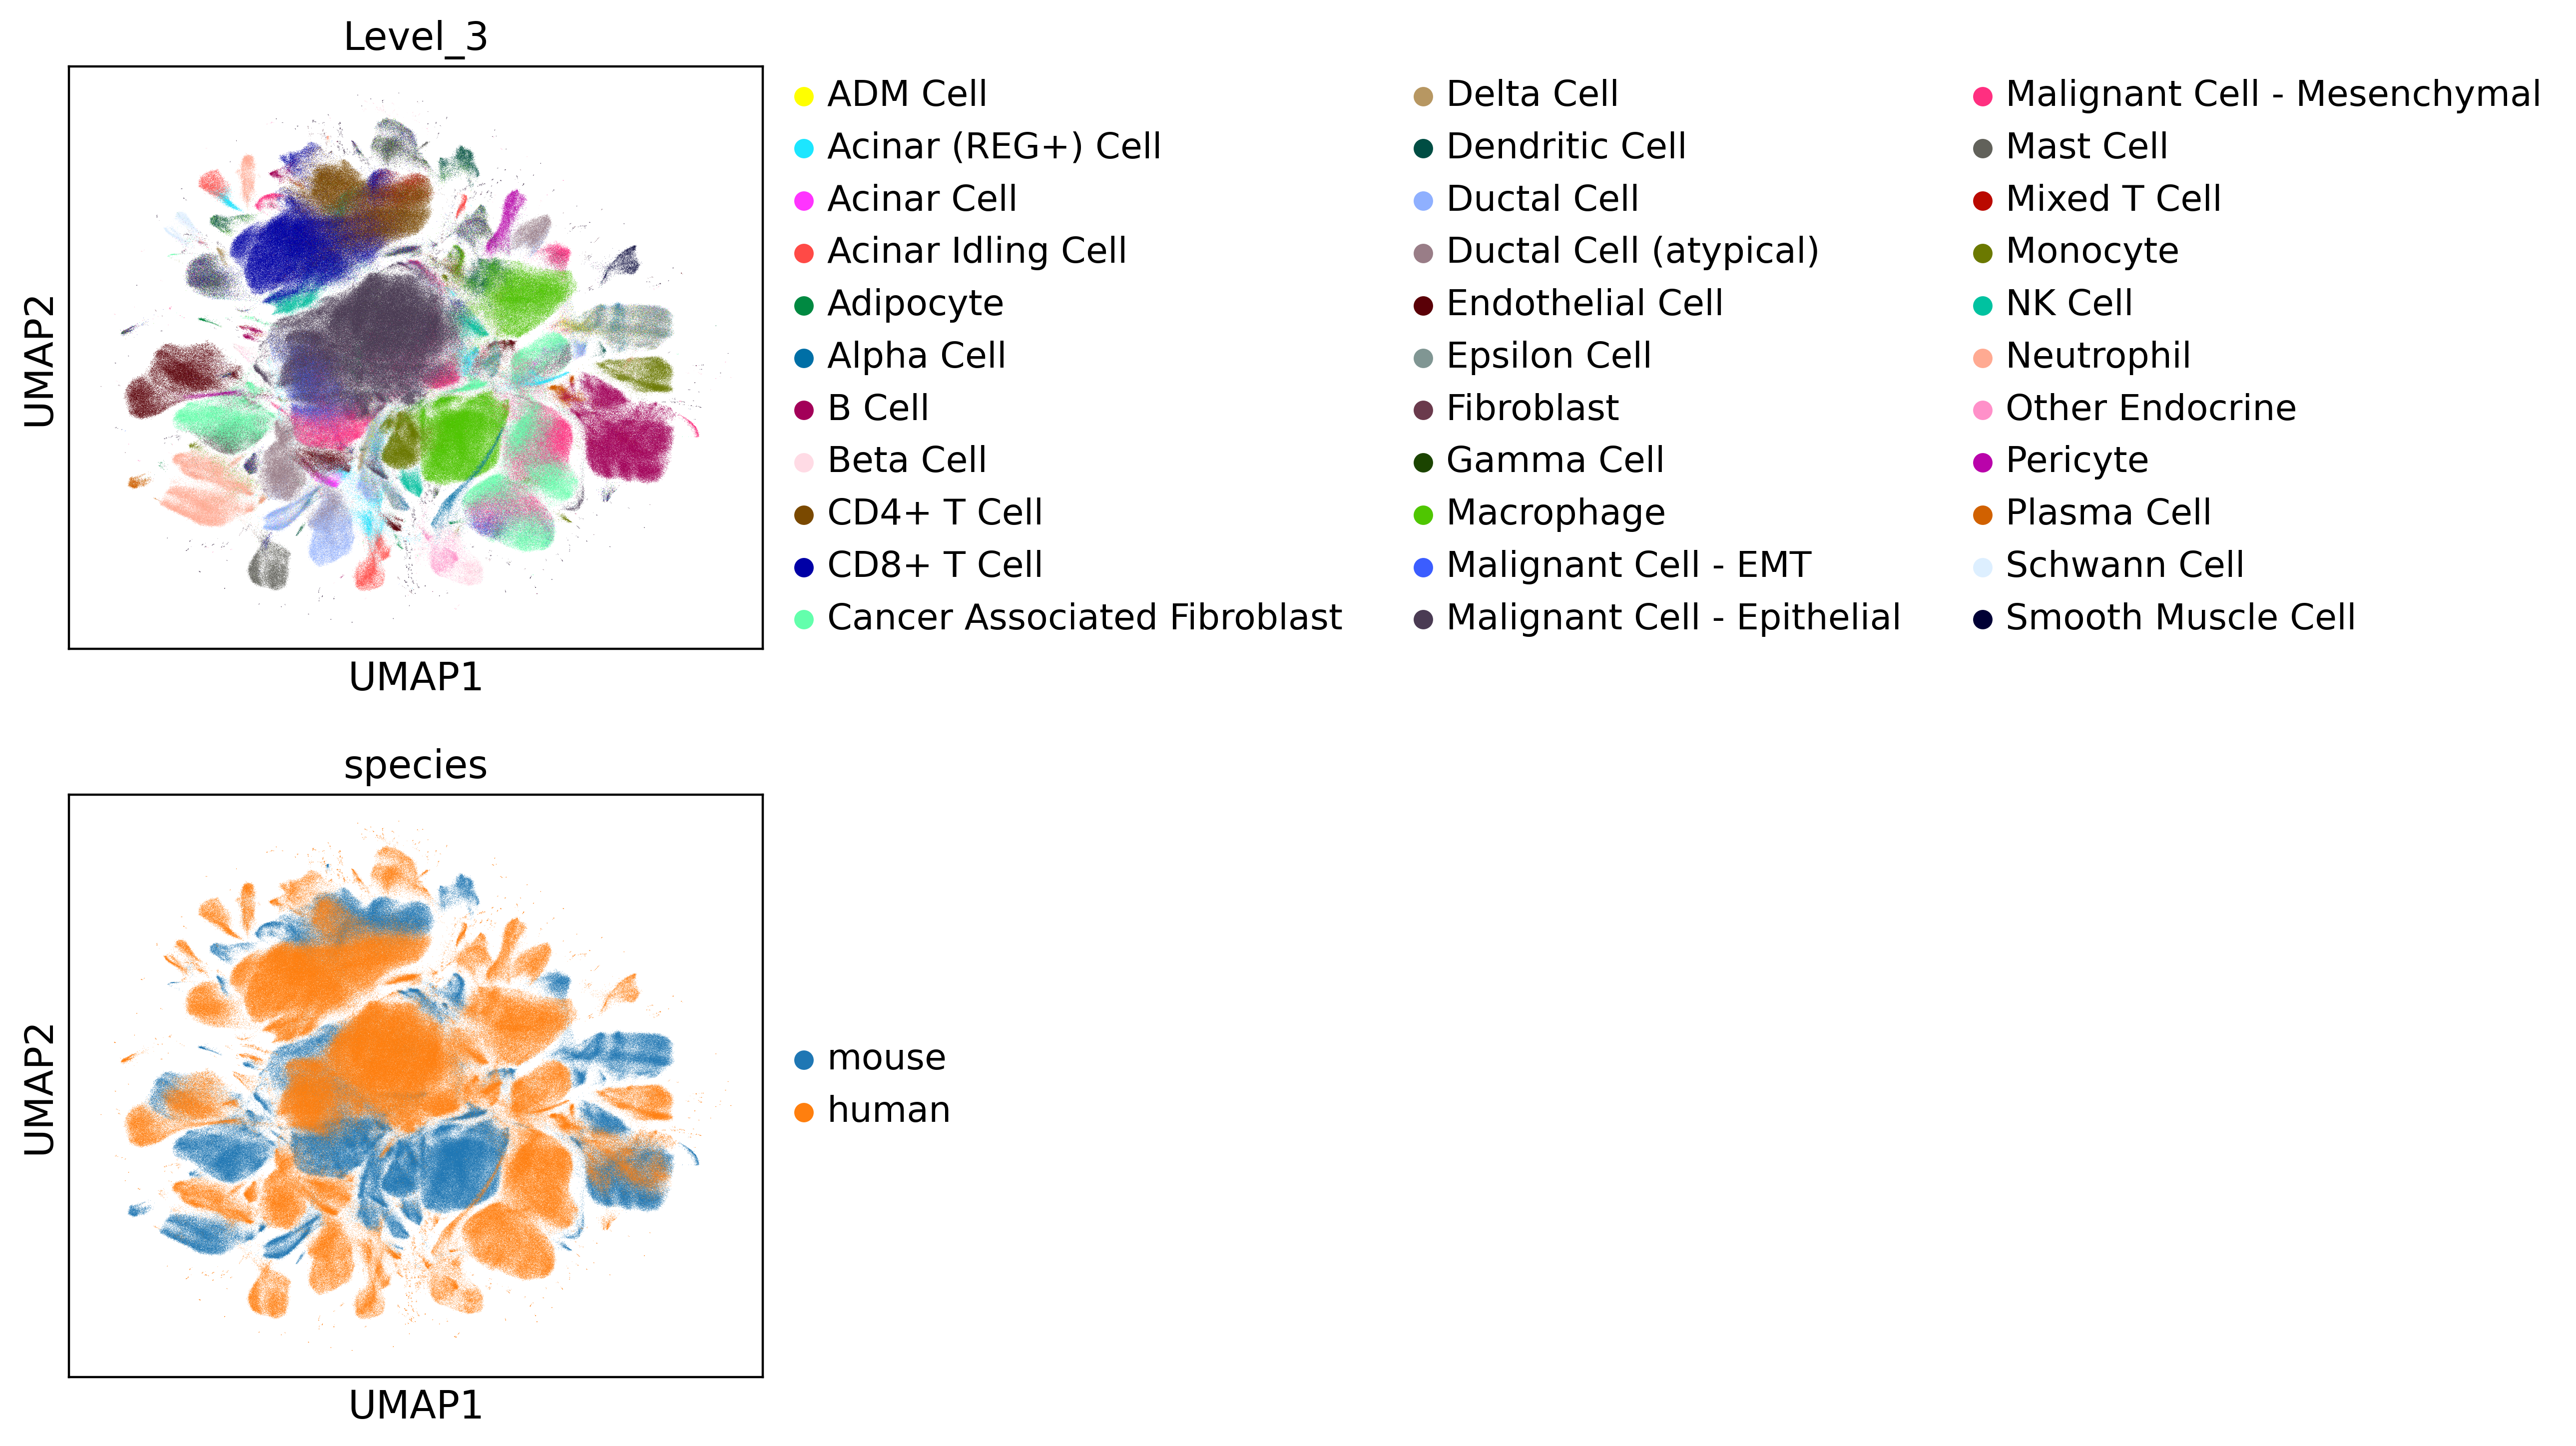

In [33]:
sc.pl.umap(adata, color = ['Level_3','species'],ncols=1)

In [ ]:
adata.write_h5ad('/mnt/storage/Daniele/atlases/cross_species_integrated.h5ad')

In [ ]:
print("hello")